In [27]:
%load_ext autoreload

%matplotlib inline
%autoreload 2

# Supress nosiy deprecation warning from inside matplotlib
import warnings
warnings.filterwarnings('ignore')

import pandas
import matplotlib.pyplot as plt
import math

import oslo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Download raw data
start = (2016, 6)
end = (2017, 8)
notexisting = [(2017, 1), (2017, 2), (2017, 3) ]
periods = sorted(set(oslo.months_between(start, end)).difference(notexisting))
for period in periods:
    try:
        filename = oslo.download_trip(*period)
    except Exception as e:
        raise RuntimeError("Could not download %d-%d: %s" % (*period, e.msg))
"done"

skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.6.1-2016.6.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.7.1-2016.7.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.8.1-2016.8.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.9.1-2016.9.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.10.1-2016.10.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.11.1-2016.11.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.12.1-2016.12.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.4.1-2017.4.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.5.1-2017.5.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.6.1-2017.6.30.csv.zip
skipping existing http:/

'done'

In [7]:
stations = oslo.read_stations()
print("%d stations" % len(stations.keys()))
stations[157]

153 stations: 


{'bounds': [{'latitude': 59.915418602160436, 'longitude': 10.762068629264832},
  {'latitude': 59.91565254992276, 'longitude': 10.762672126293182},
  {'latitude': 59.915807169665264, 'longitude': 10.762433409690855},
  {'latitude': 59.91557994562126, 'longitude': 10.761821866035461},
  {'latitude': 59.915418602160436, 'longitude': 10.762068629264832}],
 'center': {'latitude': 59.91562, 'longitude': 10.762248},
 'id': 157,
 'in_service': True,
 'number_of_locks': 30,
 'subtitle': 'mellom Norbygata og Urtegata',
 'title': 'Nylandsveien'}

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


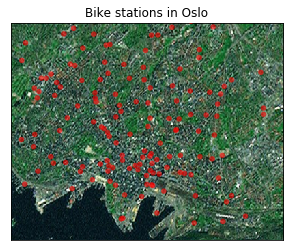

In [19]:
station_map = oslo.create_map()
# TODO: calculate mapbounds from station info / trips present in dataset
for _, station in stations.items():
    center = station['center']
    lon, lat = center['longitude'], center['latitude'] 
    poly = station_map.tissot(lon,lat,0.0005,64,facecolor='red',zorder=10,alpha=0.6)

ax = plt.gca()
plt.title("Bike stations in Oslo")
plt.show()

In [10]:
# Read in the files
# NOTE: Full set uses about 700MB of RAM, and 1 minutes to load
trips = pandas.DataFrame()
for period in periods[:1]:
    filename = "data/"+ oslo.trips_basename(*period)+'.csv'
    print('reading', filename)
    frame = pandas.read_csv(filename, index_col=None, header=0, parse_dates=[1, 3])
    trips = pandas.concat([trips, frame])
trips[:3]

reading data/trips-2016.6.1-2016.6.30.csv


,Start station,Start time,End station,End time
0,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14
1,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46
2,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14


In [11]:
number_trips = trips.shape[0]
number_trips

292302

In [12]:
trips.set_index(['Start time'], drop=False, inplace=True)
first = trips['Start time'].min()
last = trips['Start time'].max()
first, last

(Timestamp('2016-06-01 03:59:59'), Timestamp('2016-06-30 21:59:53'))

In [17]:
len(trips['End station'].unique())

110

## Cleaning the data

Return to same station    0.07093
dtype: float64

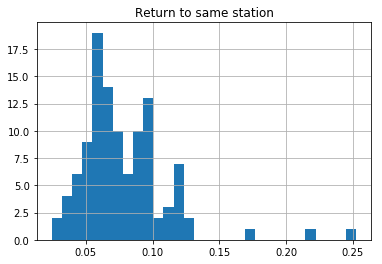

In [9]:
### Do people return to same station often?
import numpy
self_ = pandas.DataFrame(numpy.diag(relative), columns=('Return to same station',))
self_.hist(bins=30)
# About 5-10% of the trips go back to same stations
self_.median()

In [13]:
# Are own trips just errors?
own_trips = trips[trips['Start station'].eq(trips['End station'])]
percentiles = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 0.90, 0.95]
comp = pandas.DataFrame([trips['Duration'].describe(percentiles=percentiles), own_trips['Duration'].describe(percentiles=percentiles)])
# 30% of return-to-same trips are below 1 minute. Where as < 3% of all trips are below. Probably errors!
# But, also the 75 percentile is 50 minutes for return-to-same versus.
# So people do spend longer time when going back to same place. Possibly not returning the bike it and returning?
# Would be come clearer if we would remove the 'errors'
comp

,count,mean,std,min,3%,5%,10%,20%,30%,40%,50%,75%,90%,95%,max
Duration,292302,00:28:30.015425,03:30:13.330161,00:00:07,00:01:15,00:02:21,00:03:37,00:05:13,00:06:35,00:08:00,00:09:39,00:17:57,00:59:31,01:54:10,22 days 16:38:20
Duration,22948,00:40:45.077348,03:28:28.028896,00:00:07,00:00:16,00:00:18,00:00:22,00:00:32,00:00:49,00:01:29,00:06:24,00:51:11.250000,02:01:44,02:39:11.299999,19 days 02:47:19


In [14]:
# FIXME: eliminate short self-trips from analysed dataset

,Start station,Start time,End station,End time,Duration,Distance
Start time,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,610.115142
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,2917.746920
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,354.690116
2016-06-01 04:00:06,206,2016-06-01 04:00:06,233,2016-06-01 04:02:47,00:02:41,767.072410
2016-06-01 04:00:06,184,2016-06-01 04:00:06,179,2016-06-01 04:15:13,00:15:07,2986.506648


In [16]:
# Trips with missing start/end stations
missing_start = trips[pandas.isnull(trips['Start station'])]
missing_end = trips[pandas.isnull(trips['End station'])]
len(missing_start + missing_end)

0

In [15]:
# Find missing station info
def not_nan(n):
    return not math.isnan(n)
known_stations = set(stations.keys())
start_stations = set(filter(not_nan, trips['Start station'].unique()))
end_stations =  set(filter(not_nan, trips['End station'].unique()))
trip_stations = start_stations | end_stations
unknown_stations = trip_stations - known_stations
unknown_stations

NameError: name 'math' is not defined

   ## Enriching the data

In [ ]:
# Add trip durations intervals
trips['Duration'] = trips['End time'] - trips['Start time']
# Convert from nanoseconds, remove timedelta type
trips['Duration Seconds'] = pandas.Series(trips['Duration'], dtype='int64').abs() / (1000*1000*1000)

In [ ]:
# Add distance of the trip
# Note: a bit slow, since doing geometric calculations in pure Python
subs = trips
subs['Distance'] = subs.apply(lambda r: oslo.calculate_distance(stations, r), 'columns')

In [ ]:
# Add overall velocity (m/s)
trips['Velocity'] = trips['Distance'] / trips['Duration Seconds'] 
trips[:3]

## Basic characteristics

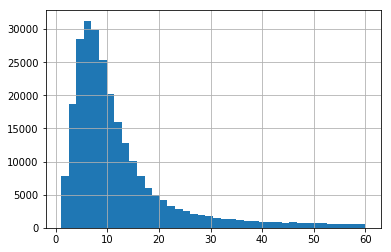

In [15]:
(trips['Duration Seconds'] / 60).hist(bins=40, range=(1, 60))

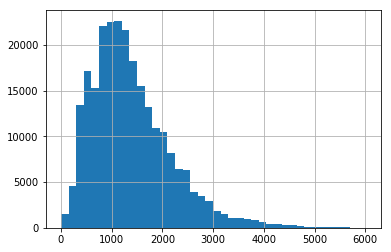

In [16]:
# 0 is a very common distance (travel back to self), ignore it
trips['Distance'].hist(bins=40, range=(1, 6000))

In [17]:
(trips['Velocity'] * 3.6).hist(bins=50, range=(1,25))

KeyError: 'Velocity'

,Start station,Start time,End station,End time,Duration,Distance,Duration Seconds,Velocity
Start time,,,,,,,,
2016-06-01 03:59:59,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14,00:02:15,610.115142,135.0,4.519371
2016-06-01 04:00:02,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46,00:18:44,2917.746920,1124.0,2.595860
2016-06-01 04:00:06,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14,00:02:08,354.690116,128.0,2.771017


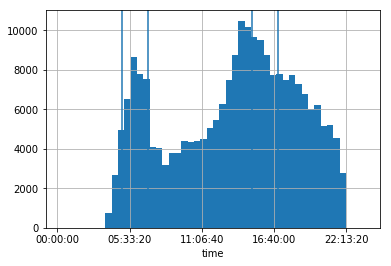

In [24]:
timeofday = trips.copy()
timeofday['timeofday'] = trips.index.time
series = timeofday['timeofday']
axs = series[trips.index.weekday < 5].hist(bins=48)
axs.axvline(x=5*3600)
axs.axvline(x=7*3600)
axs.axvline(x=15*3600)
axs.axvline(x=17*3600)

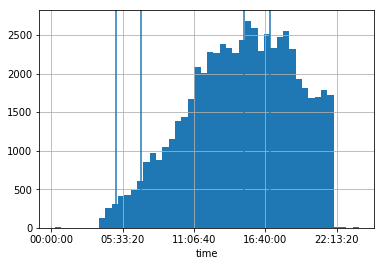

In [25]:
series = timeofday['timeofday']
axs = series[trips.index.weekday >= 5].hist(bins=48)
axs.axvline(x=5*3600)
axs.axvline(x=7*3600)
axs.axvline(x=15*3600)
axs.axvline(x=17*3600)

## Station connectivity

In [20]:
# How are stations connected to eachother?
period = trips['2016-06-03':'2016-07-13']
cross = pandas.crosstab(period['Start station'], period['End station'])
relative = cross.div(cross.sum(axis=1), axis=0)
relative[:3]

End station,157,159,160,161,162,163,164,167,170,172,...,287,288,290,291,292,293,294,298,301,302
Start station,,,,,,,,,,,,,,,,,,,,,
157,0.123377,0.000000,0.005348,0.000000,0.004584,0.029794,0.019481,0.003056,0.000000,0.002292,...,0.010313,0.014515,0.000382,0.000000,0.001910,0.001528,0.028648,0.000000,0.007257,0.012987
159,0.003911,0.099739,0.003911,0.004563,0.019557,0.015645,0.011082,0.001956,0.000000,0.006519,...,0.003911,0.005215,0.000652,0.003259,0.003259,0.003911,0.020209,0.001956,0.002608,0.009126
160,0.004156,0.002267,0.090669,0.003022,0.006045,0.011334,0.011711,0.007934,0.000756,0.001889,...,0.012089,0.006045,0.006045,0.000756,0.017756,0.007934,0.022667,0.003022,0.007178,0.019267


[44, 20, 18, 14, 7, 7]


/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


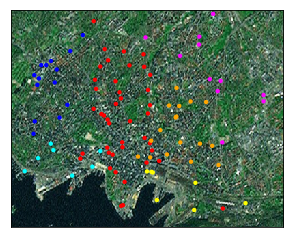

In [36]:
df = trips['2016-06-03':'2016-07-03']
df = df[df.index.weekday >= 5]
clustered = oslo.cluster_connected(df, n_clusters=6)
print([len(c) for c in clustered])
oslo.plot_station_groups(stations, clustered)

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


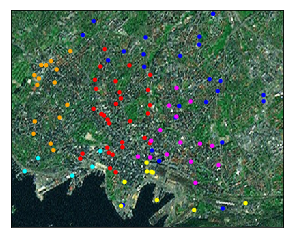

In [35]:
df = trips[trips.index.weekday < 5 ]
#df = df.between_time('10:00', '12:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


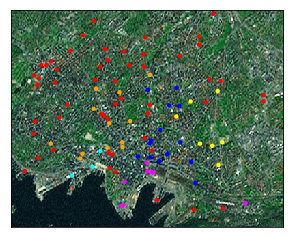

In [34]:
df = trips[trips.index.weekday < 5 ]
df = df.between_time('5:00', '8:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

In [148]:
# Calculate connenectivity within clusters, and between them
def cluster_id_for_station(clusters, station_id):
    for cluster_idx, cluster in enumerate(clusters):
        if station_id in cluster:
            return cluster_idx
    return None
            
    
def cluster_series(clusters):
    s = {}
    for station_id in stations_by_id.keys():
        cluster_id = cluster_id_for_station(clusters, station_id)
        if cluster_id is not None:
            s[station_id] = cluster_id
    series = pandas.Series(s, dtype='int64')
    return series

def cluster_stats(df, clusters):

    def trips_for_cluster(counts, cluster_id):
        return counts[counts['Cluster'] == cluster_id].sum()[1:]
    
    self_trips = df[df['End station'] == df['Start station']]
    without_self = df[df['End station'] != df['Start station']]
    trips_by_end = without_self.groupby('End station').count()['Start station']
    trips_by_start = without_self.groupby('Start station').count()['End station']
    trip_counts = pandas.DataFrame.from_dict({
        'Outbound': trips_by_start,
        'Inbound': trips_by_end,
        'Internal': self_trips.count()['Start station'],
        'Cluster': cluster_series(clusters),
    })
    clustered_trips = [trips_for_cluster(trip_counts, idx) for idx, _ in enumerate(clustered)]

    return pandas.DataFrame(data=clustered_trips)

stats = cluster_stats(trips, clustered)

#clusters

# TODO: sanity check clustering

#t[t['Cluster'] == 2]['Start station'].sum()

#cluster_stats(clustered, trips['2016-06-03':'2016-06-03'])

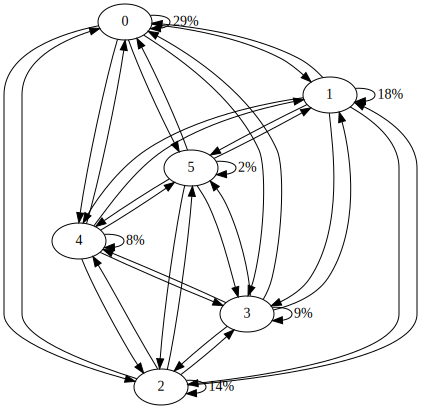

In [155]:
# Visualize clustered connectivity
from graphviz import Digraph

# FIXME: need to have data for which cluster edge goes to
total_trips = stats.sum().sum()
dot = Digraph(comment='The Round Table')
label_threshold = 3
for cluster_id, data in stats.iterrows():
    node_name = str(cluster_id)
    dot.node(str(cluster_id), node_name)
    
    for target_id in range(0, len(stats)):
        if target_id == cluster_id:
            n = data['Internal']/total_trips * 100
            dot.edge(str(cluster_id), str(cluster_id), label="%d%%" % (n,))
        else:
            n = data['Outbound']/total_trips * 100
            label = None
            if n >= label_threshold:
                label = "%d%%" % (n,)
            dot.edge(str(cluster_id), str(target_id), label=label)

dot
#dot.render('test-output/round-table.gv', view=True)
    

In [124]:
# What travel patterns are there during the day?
# How to find out?